In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft
import time
from pandas import DataFrame

In [18]:
def initialize_values():
    training_path = "NguyenAmHuanLuyen-16k"
    test_path = "NguyenAmKiemThu-16k"
    training_folders = [folder for folder in os.listdir(training_path) if os.path.isdir(os.path.join(training_path, folder))]
    test_folders = [folder for folder in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, folder))]
    vowel_files = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"]
    frame_duration = 0.02
    frame_shift = frame_duration/4
    N_FFT_array = [512, 1024, 2048]

    return training_path, training_folders, test_path, test_folders, vowel_files, frame_duration, frame_shift, N_FFT_array

In [19]:
import warnings

def process_speech_signal(path, folder, file, frame_duration, frame_shift):
    filepath = f"{path}/{folder}/{file}"
    warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
    Fs, data = wavfile.read(filepath)
    T = 1 / Fs                            # Thoi gian lay mau
    n = len(data)                         # So mau tin hieu
    t = n * T                             # Thoi gian tin hieu
    signal = data
    data = data / abs(max(data))          # Chuan hoa bien do ve [-1, 1]
    # Number of samples in one frame (20ms)
    frame_len = round(frame_duration * Fs)
    # Number of samples to shift the frame (10ms)
    frame_shift_len = round(frame_shift * Fs)
    # Total number of frames
    n_f = int(np.floor((n - frame_len) / frame_shift_len) + 1)
    # Split the data into frames
    list_frames = [data[i * frame_shift_len:i * frame_shift_len + frame_len] for i in range(n_f)]
    frames = np.array(list_frames)
    # Calculate Short-Time Energy (STE) for each frame
    ste = np.sum(np.square(frames), axis=1)
    # Normalize STE to the range [0, 1]
    ste = ste / max(ste)
    # IDs containing speech frames
    id = np.where(ste >= 0.03)[0]
    # Calculate the length of the ID array
    len_id = len(id)
    distance = int(np.ceil((id[-1] - id[0]) / 3))
    frame_start = id[0] + distance
    frame_end = id[0] + 2 * distance

    # Plotting the signal and the STE
    # plt.figure()
    # plt.plot(np.arange(0, len(signal) * T, T), signal) # Original signal
    # plt.title("Signal and (STE) of the Signal " + f"{folder}/{file}")
    # # Vertical lines for speech marks
    # plt.axvline(x=(id[0]) * frame_shift_len * T, color='r', linestyle='--', label="Start of Speech")
    # plt.axvline(x=(id[-1]) * frame_shift_len * T, color='r', linestyle='--', label="End of Speech")
    # plt.axvline(x=(frame_start) * frame_shift_len * T, color='b', linestyle='--', label="Start of Stable Speech")
    # plt.axvline(x=(frame_end) * frame_shift_len * T, color='b', linestyle='--', label="End of Stable Speech")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude")
    # plt.legend()
    # plt.tight_layout()
    # plt.show() 
    return frames, frame_start, frame_end
# Example usage
# frames, frame_start, frame_end = process_speech_signal("NguyenAmHuanLuyen-16k", "23MTL", "a.wav", 0.02, 0.01)
# frames, frame_start, frame_end = process_speech_signal("NguyenAmHuanLuyen-16k", "23MTL", "o.wav", 0.02, 0.01)
# frames, frame_start, frame_end = process_speech_signal("NguyenAmHuanLuyen-16k", "23MTL", "u.wav", 0.02, 0.01)
# frames, frame_start, frame_end = process_speech_signal("NguyenAmHuanLuyen-16k", "23MTL", "e.wav", 0.02, 0.01)
# frames, frame_start, frame_end = process_speech_signal("NguyenAmHuanLuyen-16k", "23MTL", "i.wav", 0.02, 0.01)



In [20]:
def find_characteristic_vector_fft(frames, frame_start, frame_end, N_FFT):
    # window = hamming(frames.shape[1]) # tao cua so hamming co do dai bang do dai khung tin hieu, giup giam hieu ung ro ri pho (Spectral Leakage)
    # window = np.ones(frames.shape[1]) # tao cua so hinh chu nhat
    # window = np.hanning(frames.shape[1]) # tao cua so hanning
    # window = np.blackman(frames.shape[1]) # tao cua so blackman
    window = np.hamming(frames.shape[1]) # tao cua so hamming

    # Khởi tạo vector đặc trưng
    characteristic_vector = np.zeros(N_FFT)
    for k in range(frame_start, frame_end + 1):
        frame_vector = window * frames[k]
        kernel = np.array([1/3, 1/3, 1/3]) # tao bo loc trung binh de lam muot tin hieu
        frame_filtered = np.convolve(frame_vector, kernel, mode='same')
        characteristic_vector += np.abs(fft(frame_filtered, N_FFT))

        # frame_vector = window * frames[k]
        # characteristic_vector += np.abs(fft(frame_vector, N_FFT))
    characteristic_vector /= (frame_end + 1 - frame_start) # vector dac trung trung binh
    return characteristic_vector
    

def draw_characteristic_vectors_fft(vowel_files, vectors, N_FFT, title):
    Fs = 16000
    freq = np.linspace(0, Fs/2, int(N_FFT/2))
    plt.figure(figsize=(10, 5))
    plt.plot(freq, vectors[0, :int(N_FFT/2)], 'r', label=vowel_files[0])
    plt.plot(freq, vectors[1, :int(N_FFT/2)], 'g', label=vowel_files[1])
    plt.plot(freq, vectors[2, :int(N_FFT/2)], 'b', label=vowel_files[2])
    plt.plot(freq, vectors[3, :int(N_FFT/2)], 'y', label=vowel_files[3])
    plt.plot(freq, vectors[4, :int(N_FFT/2)], 'k', label=vowel_files[4])
    plt.title(title)
    plt.xlabel('Tần số (Hz)')
    plt.ylabel('Biên đô FFT')
    plt.legend()
    plt.show()
    

def training_for_vowel_recognition_using_FFT(training_path, training_folders, vowel_files, frame_duration, frame_shift, N_FFT):
    vowels_size = len(vowel_files)
    folders_size = len(training_folders)

    vectors = np.zeros((vowels_size, N_FFT))
    for i in range(vowels_size):
        sum_of_characteristic_vectors = np.zeros(N_FFT)
        for j in range(folders_size):
            # Phan doan tin hieu de lay vung tin hieu on dinh
            frames, frame_start, frame_end = process_speech_signal(training_path, training_folders[j], vowel_files[i], frame_duration, frame_shift)
            # Tinh vector dac trung
            sum_of_characteristic_vectors += find_characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
        vectors[i, :] = sum_of_characteristic_vectors / folders_size

    title = f"Vector đặc trưng FFT với N_FFT = {N_FFT}"
    draw_characteristic_vectors_fft(vowel_files, vectors, N_FFT, title)
    
    return vectors

In [21]:
def euclidean_distance(vector1, vector2):
    distance = np.sqrt(np.sum((vector1 - vector2) ** 2))
    return distance

def calc_recognition_accuracy(confusion_matrix, folders_size, vowel_files_size):
    total_percent = 0
    for i in range(vowel_files_size):
        # Tinh do chinh xac nhan dang moi nguyen am
        percent = float(confusion_matrix[i + 1][i + 1]) / folders_size * 100
        confusion_matrix[i + 1][vowel_files_size + 1] = percent
        total_percent += percent
    confusion_matrix[vowel_files_size + 1][vowel_files_size + 1] = total_percent / vowel_files_size
    # print(confusion_matrix)
    return confusion_matrix

def testing_for_vowel_recognition_using_FFT(test_path, test_folders, vowel_files, frame_duration, frame_shift, N_FFT, vectors):
    folders_size = len(test_folders)
    vowel_files_size = len(vowel_files)
    vowels = ["a", "e", "i", "o", "u"]

    result = np.zeros((folders_size + 1, vowel_files_size + 1), dtype=object)
    result[0, 0] = ""
    result[1:, 0] = test_folders
    result[0, 1:] = vowels

    confusion_matrix = [
        ["", "a", "e", "i", "o", "u", "Độ chính xác(%)"],
        ["a", 0, 0, 0, 0, 0, 0],
        ["e", 0, 0, 0, 0, 0, 0],
        ["i", 0, 0, 0, 0, 0, 0],
        ["o", 0, 0, 0, 0, 0, 0],
        ["u", 0, 0, 0, 0, 0, 0],
        ["Độ chính xác trung bình(%)", "", "", "", "", "", 0]
    ]


    time_processing_vowels = []
    for i in range(folders_size):
        time_processing_vowel = 0
        for j in range(vowel_files_size):
            start_time = time.time()

            # Danh dau vung co dac trung pho on dinh dac trung cho nguyen am
            frames, frame_start, frame_end = process_speech_signal(test_path, test_folders[i], vowel_files[j], frame_duration, frame_shift)
            # Tinh vector dac trung cho nguyen am bang FFT cua tung nguyen am cua tung nguoi noi
            characteristic_vector_of_current_vowel = find_characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
            
            # Tinh khoang cach euclidean_distance giua vector nguyen am kiem thu va cac vector huan luyen cua 5 nguyen am [a, e, i, o, u] de nhan dang nguyen am
            min_distance = euclidean_distance(vectors[0, :], characteristic_vector_of_current_vowel)
            index = 0
            for k in range(1, vowel_files_size):
                distance = euclidean_distance(vectors[k, :], characteristic_vector_of_current_vowel)
                if distance < min_distance:
                    min_distance = distance
                    index = k

            # Dien ket qua vao bang ket qua va ma tran nham lan
            result[i + 1, j + 1] = vowels[index]
            confusion_matrix[j + 1][index + 1] += 1

            end_time = time.time()
            time_processing_vowel += (end_time - start_time)
            print(f"Consuming time for {vowels[index]} in {test_path}/{test_folders[i]}: {end_time - start_time}")
        
    # Tinh phan tram nhan dang dung va sai
    confusion_matrix = calc_recognition_accuracy(confusion_matrix, len(test_folders), len(vowel_files))

    # print(result)
    # print(confusion_matrix)
    return result, confusion_matrix

In [22]:
def draw_result_matrix(result_matrix, N_FFT):
    # Hien thi bang ket qua
    figure, axes = plt.subplots()
    title = f"Kết quả nhận dạng nguyên âm bằng FFT với N_FFT = {N_FFT}"
    axes.set_title(title, color="blue", loc='center')
    axes.axis('off')
    axes.axis('tight')
    axes.table(cellText=result_matrix, loc='center')
    figure.tight_layout()
    plt.show()


def draw_confusion_matrix(confusion_matrix, N_FFT):
    # Dinh dang ket qua hien thi do chinh xac lam tron 4 chu so thap phan, cac gia tri khong phai so thuc thi hien thi rong
    for row in confusion_matrix[1:]:
        if type(row[-1]) == float:  # Kiem tra dinh dang so thuc
            row[-1] = "{:.1f}".format(row[-1])
        else:
            row[-1] = ""  # Neu khong phai so thuc thi hien thi rong
    # Chuyen confusion_matrix thanh DataFrame de xu ly de dang hon
    df_cm = DataFrame(
        [row[1:] for row in confusion_matrix[1:]],  # Loai tru cot tieu de, confusion_matrix[1:] la loai tru hang tieu de trong confusion_matrix
        columns=confusion_matrix[0][1:],  # Hang dau tien de hien thi ten nguyen am nhan dang duoc, o dau tien de trong
        index=[row[0] for row in confusion_matrix[1:]]  # Cot dau tien de hien thi folder nguoi noi, confusion_matrix[1:] la loai tru hang tieu de trong confusion_matrix
    )
    # Hien thi ma tran nham lan
    figure, axes = plt.subplots(figsize=(11, 4))
    title = f"Ma trận nhầm lẫn bằng FFT với N_FFT = {N_FFT}"
    axes.set_title(title, color="blue", loc='center')
    axes.axis('off')  # Ẩn các trục
    axes.axis('tight')  # Ẩn khoảng trắng thừa
    tab = axes.table(cellText=df_cm.values, cellLoc='center', loc='center', rowLabels=df_cm.index, colLabels=df_cm.columns)
    tab.auto_set_font_size(False)
    tab.set_fontsize(10)
    tab.scale(1, 1.5)
    figure.tight_layout()

    # Highlight hang co do chinh xac cao nhat va thap nhat
    max_index = df_cm.iloc[:-1, -1].astype(float).idxmax()  # Do chinh xac cao nhat khong tinh do chinh xac trung binh
    min_index = df_cm.iloc[:-1, -1].astype(float).idxmin()  # Do chinh xac thap nhat khong tinh do chinh xac trung binh

    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_text_props(color='black', fontweight='bold')
            cell.set_facecolor('lightgrey')

    for (i, row) in enumerate(df_cm.iterrows(), start=1):
        if row[0] == max_index :  # Highlight hang do chinh xac cao nhat
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('lightgreen')
        if row[0] == min_index:  # Highlight hang do chinh xac thap nhat
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('salmon')

    plt.show()

In [23]:
def Bai2(training_path, training_folders, test_path, test_folders, vowel_files, N_FFT_array, frame_duration, frame_shift):
    for N_FFT in N_FFT_array:
        # Huan luyen nhan dang nguyen am bang FFT
        vectors = training_for_vowel_recognition_using_FFT(training_path, training_folders, vowel_files, frame_duration, frame_shift, N_FFT)
        # Kiem thu nhan dang nguyen am bang FFT
        result, confusion_matrix = testing_for_vowel_recognition_using_FFT(test_path, test_folders, vowel_files, frame_duration, frame_shift, N_FFT, vectors)
        # Hien thi bang ket qua nhan dang
        draw_result_matrix(result, N_FFT)
        # Hien thi ma tran nham lan
        draw_confusion_matrix(confusion_matrix, N_FFT)


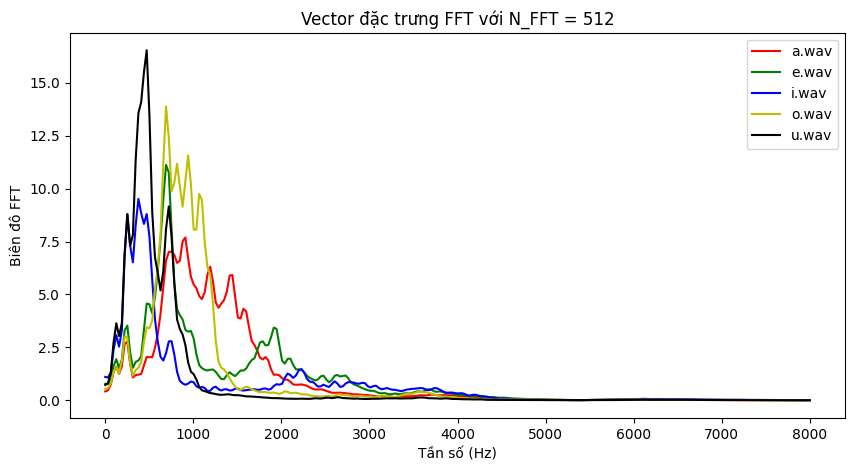

Consuming time for a in NguyenAmKiemThu-16k/22MHL: 0.003653287887573242
Consuming time for e in NguyenAmKiemThu-16k/22MHL: 0.0028798580169677734
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.0026319026947021484
Consuming time for o in NguyenAmKiemThu-16k/22MHL: 0.0027933120727539062
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.002421140670776367
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.0044841766357421875
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.0044209957122802734
Consuming time for i in NguyenAmKiemThu-16k/16FTH: 0.003960132598876953
Consuming time for o in NguyenAmKiemThu-16k/16FTH: 0.004213094711303711
Consuming time for u in NguyenAmKiemThu-16k/16FTH: 0.004313945770263672
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.004454851150512695
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.003654003143310547
Consuming time for i in NguyenAmKiemThu-16k/03MAB: 0.004113912582397461
Consuming time for o in NguyenAmKiemThu-16k/03MAB: 0.004272

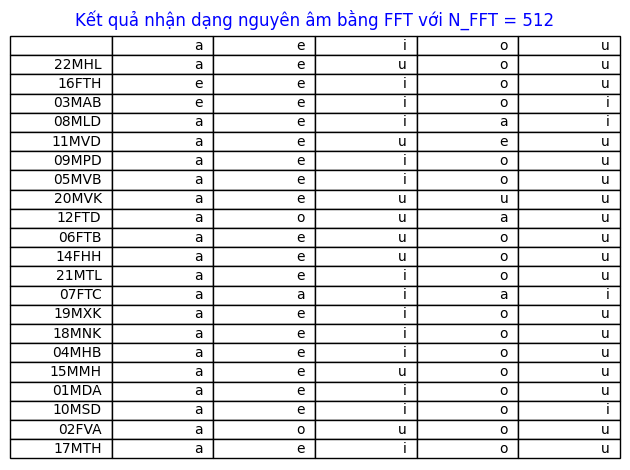

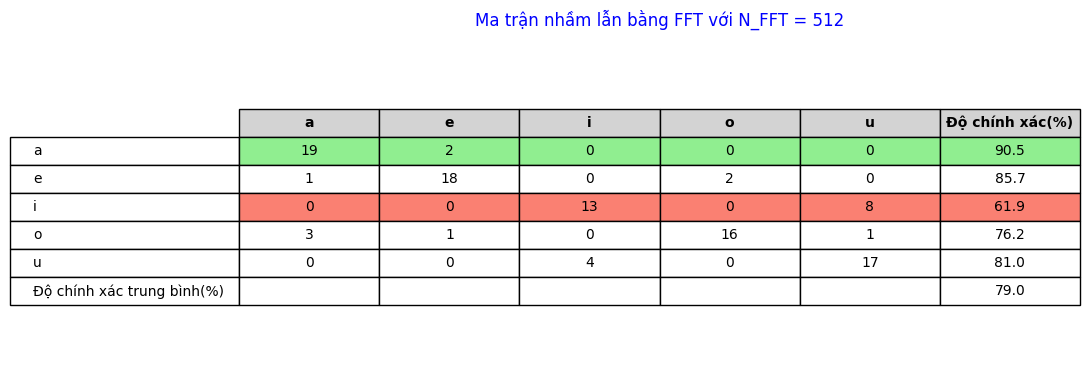

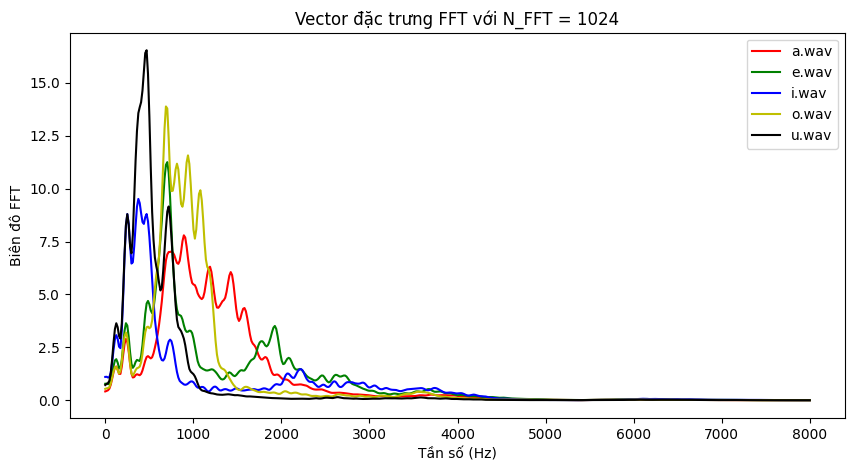

Consuming time for a in NguyenAmKiemThu-16k/22MHL: 0.00699305534362793
Consuming time for e in NguyenAmKiemThu-16k/22MHL: 0.00454401969909668
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.004107952117919922
Consuming time for o in NguyenAmKiemThu-16k/22MHL: 0.0044209957122802734
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.004727840423583984
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.007810831069946289
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.008917093276977539
Consuming time for i in NguyenAmKiemThu-16k/16FTH: 0.007333040237426758
Consuming time for o in NguyenAmKiemThu-16k/16FTH: 0.004694938659667969
Consuming time for u in NguyenAmKiemThu-16k/16FTH: 0.0070002079010009766
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.0056378841400146484
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.0035140514373779297
Consuming time for i in NguyenAmKiemThu-16k/03MAB: 0.004971981048583984
Consuming time for o in NguyenAmKiemThu-16k/03MAB: 0.006531715

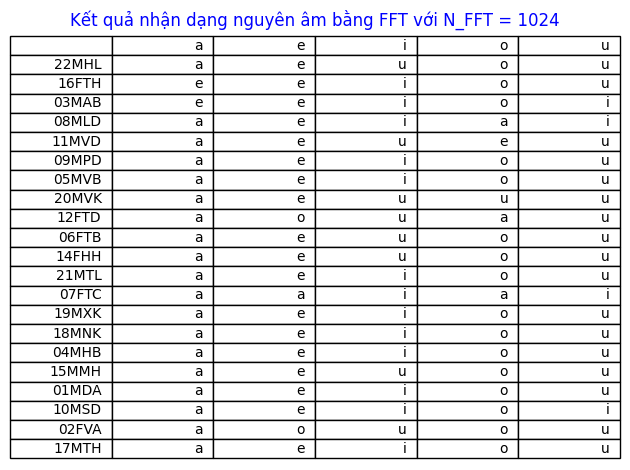

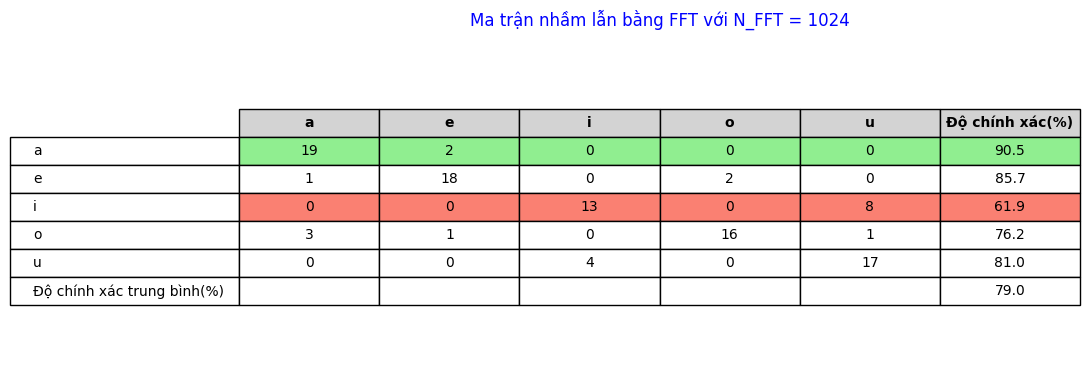

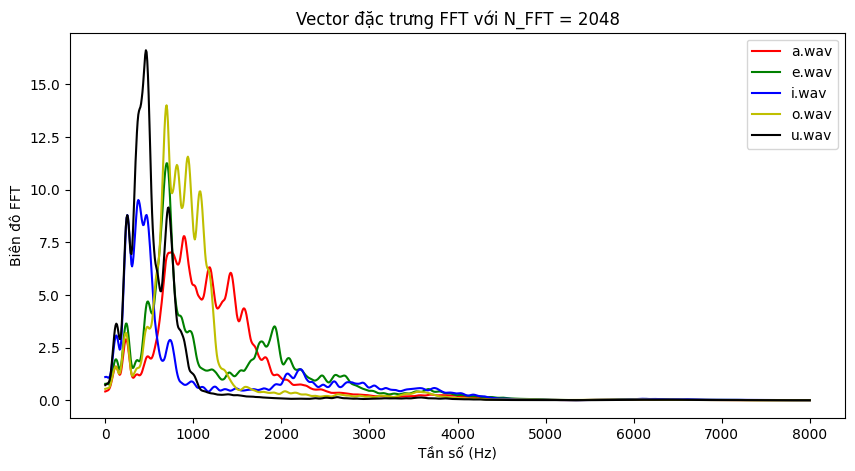

Consuming time for a in NguyenAmKiemThu-16k/22MHL: 0.0033500194549560547
Consuming time for e in NguyenAmKiemThu-16k/22MHL: 0.0036580562591552734
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.0035631656646728516
Consuming time for o in NguyenAmKiemThu-16k/22MHL: 0.003648996353149414
Consuming time for u in NguyenAmKiemThu-16k/22MHL: 0.0030820369720458984
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.005739927291870117
Consuming time for e in NguyenAmKiemThu-16k/16FTH: 0.007367134094238281
Consuming time for i in NguyenAmKiemThu-16k/16FTH: 0.004499912261962891
Consuming time for o in NguyenAmKiemThu-16k/16FTH: 0.005004167556762695
Consuming time for u in NguyenAmKiemThu-16k/16FTH: 0.005327939987182617
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.004017829895019531
Consuming time for e in NguyenAmKiemThu-16k/03MAB: 0.004156827926635742
Consuming time for i in NguyenAmKiemThu-16k/03MAB: 0.0048351287841796875
Consuming time for o in NguyenAmKiemThu-16k/03MAB: 0.005768

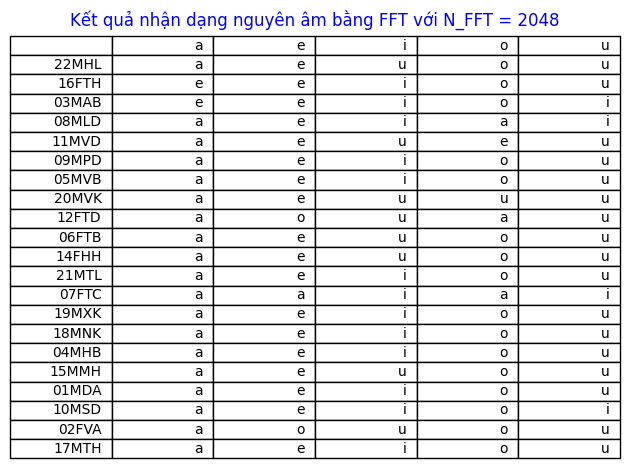

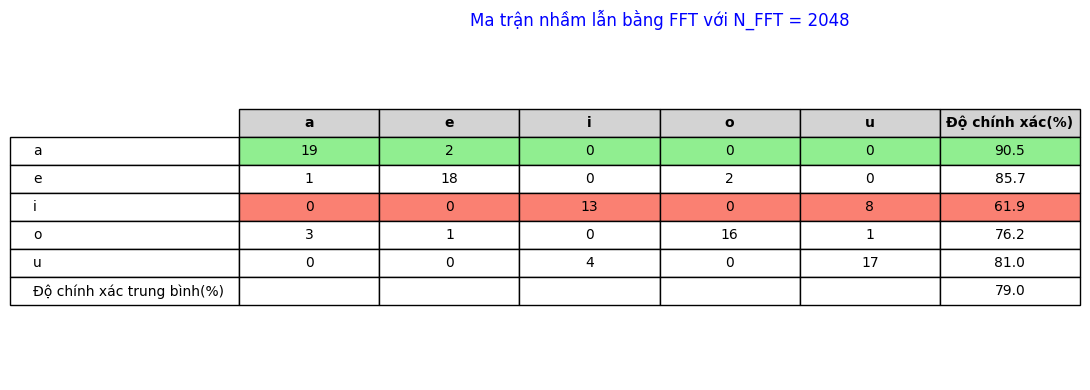

In [24]:
# Khoi tao gia tri
training_path, training_folders, test_path, test_folders, vowel_files, frame_duration, frame_shift, N_FFT_array = initialize_values()
#Bai2 - Nhan dang nguyen am dung dac trung pho FFT
Bai2(training_path, training_folders, test_path, test_folders, vowel_files, N_FFT_array, frame_duration, frame_shift)